# Zwicker Tone
The purpose of this notebook is to generate audio files capable of demonstrating the auditory illusion known as the Zwicker Tone as outlined in the article “Negative Afterimage” in Hearing from The Journal of the Acoustical Society of America (1964).

In the experiment Gaussian white-noise was generated and then a band-stop filter was applied to it. The subjects then listened to the modified audio for one minute after which they were asked to describe what they heard once the noise was switched off. Of the twenty subjects eighteen perceived a soft sinusoidal tone for about 5-10 seconds.

## Tools
To create the audio files several packages will be needed primarily `numpy` for generating white-noise signals, `scipy` for performing a Fourier transform, and converting the numerical data into an audio file.

In [3]:
import numpy as np
import scipy.fft as fft
from scipy.io.wavfile import write
import IPython
import matplotlib.pyplot as plt

## White-Noise
The first step is to generate gaussian white-noise, which we do by drawing sufficient samples from a normal distribution.

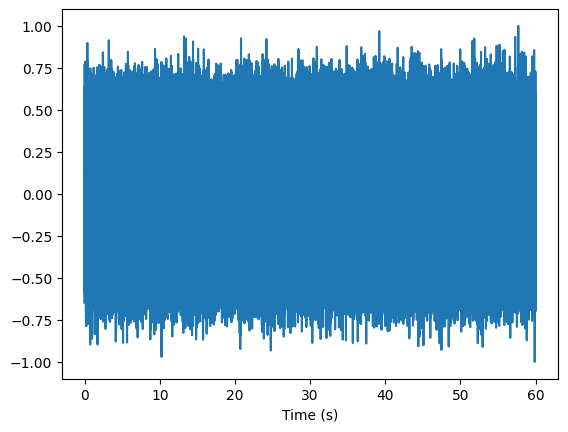

In [4]:
# The sample rate for the audio file to be generated in Hz.
SAMPLE_RATE = 44100
# The duration of the audio file to be generated in seconds.
T = 60
# The lower bound of the bandstop filter to be applied.
LOW_PASS = 2200
# The upper bound of the bandstop filter to be applied.
HIGH_PASS = 3300

np.random.seed(42)

# Genrate gaussian white-noise by drawing values from a normal distribution.
noise = np.random.normal(size = (T*SAMPLE_RATE))
# Normalize the white-noise so that high values aren't clipped.
noise /= np.max(abs(noise))

# Write the raw white-noise to an audio file.
write("../audio/white_noise.wav", SAMPLE_RATE, noise)

# Plot the raw values.
t= np.arange(0, T, 1/SAMPLE_RATE)
plt.plot(t, noise)
plt.xlabel("Time (s)");

## The Fourier Transform
In order to apply a band-stop filter we can compute the Fourier transform of the signal so that we can view it in the frequency domain.

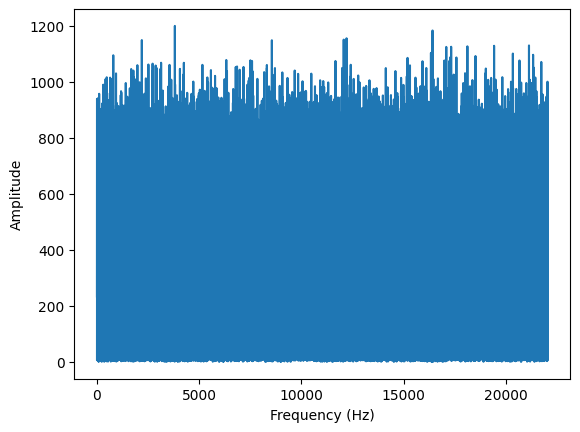

In [5]:
# Calculate the real valued Fourier transform of the signal.
ft = fft.rfft(noise)

# Calculate the corresponding frequencies.
freq = fft.rfftfreq(noise.size, d = 1/SAMPLE_RATE)

# Plot the frequencies against the absolute value of the Fourier transform 
# to get the amplitude of each component.
plt.plot(freq, abs(ft))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude");


## Applying the Band-stop Filter
Now that we can view our signal in the frequency domain we can simply select all frequencies in our band and supress them.

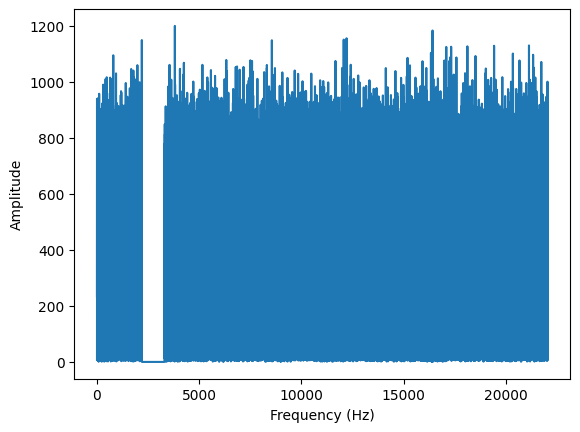

In [6]:
# Zero out the components that fall within the band.
band = (freq >= LOW_PASS) * (freq <= HIGH_PASS)
ft[band] = 0

plt.plot(freq, abs(ft))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude");

Finally, all that remains is to transform our modified signal back from the frequency domain by computing the inverse-real valued Fourier transform.

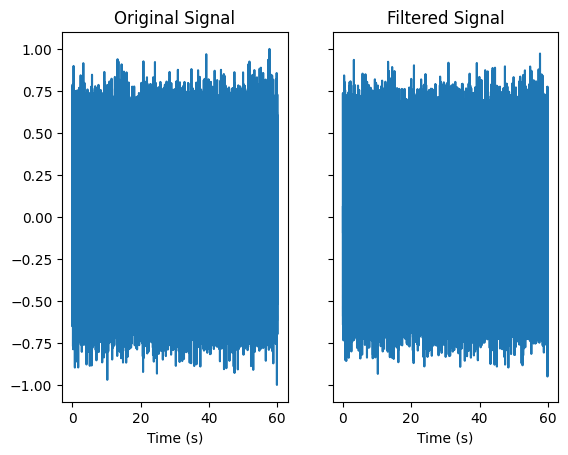

In [7]:
ift = np.fft.irfft(ft)

fig, ax = plt.subplots(1, 2, sharey= True)

ax[0].plot(t, noise)
ax[0].set_xlabel("Time (s)")
ax[0].set_title("Original Signal")

ax[1].plot(t, ift)
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Filtered Signal")
write("../audio/zwicker_tone_{}-{}.wav".format(LOW_PASS, HIGH_PASS), SAMPLE_RATE, ift);


## Importance of Duration
The experiments conducted showed that the minimum duration of the stimulus required to produce an effect was approximately 500 ms. Moreover, the duration of the effect perceived was related to the duration of the stimulus. In one modified version of the stimulus they alternated the simulus from 500 ms noise burst to 500 ms silence. In this experiment the result produced in subject was the perception of a "Bing" noise.

Lets try to replicate this.

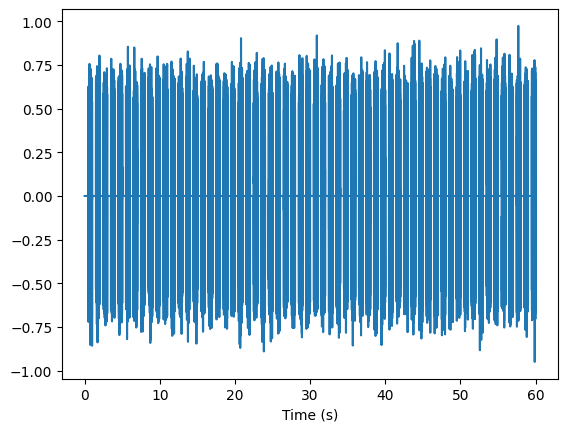

In [8]:
window = SAMPLE_RATE // 2
for i in range(T):
    ift[window*2*i: window*((2*i)+1)] = 0

plt.plot(t, ift)
plt.xlabel("Time (s)")

write("../audio/alternating_zwicker_tone_{}-{}.wav".format(LOW_PASS, HIGH_PASS), SAMPLE_RATE, ift);

## A Binaural Version
Another experiment the researchers conducted was to create two different versions of the stimulus (suppressing different frequencies from the signal) and to play each through a different headphone. In this experiment two different tones were perceived.

In [10]:
def get_normalized_white_noise(samples):
    white_noise = np.random.normal(size = (T*SAMPLE_RATE))
    white_noise /= np.max(abs(white_noise))
    return white_noise

In [11]:
def apply_band_stop_filter(signal, sample_rate, low_pass, high_pass):
    ft = fft.rfft(signal)
    freq = fft.rfftfreq(signal.size, d = 1/sample_rate)

    band = (freq >= low_pass) * (freq <= high_pass)
    ft[band] = 0

    return fft.irfft(ft)

In [12]:
L_LOW_PASS, L_HIGH_PASS = 2200, 3300
R_LOW_PASS, R_HIGH_PASS = 1000, 1500

l_channel = get_normalized_white_noise(T*SAMPLE_RATE)
l_channel = apply_band_stop_filter(l_channel, SAMPLE_RATE, 2200, 3300)

r_channel = get_normalized_white_noise(T*SAMPLE_RATE)
r_channel = apply_band_stop_filter(r_channel, SAMPLE_RATE, 1000, 1500)

signal = np.stack([l_channel, r_channel], axis=1)

write("../audio/binaural_zwicker_tone_{}-{}_{}-{}.wav".format(L_LOW_PASS, L_HIGH_PASS, R_LOW_PASS, R_HIGH_PASS), SAMPLE_RATE, signal);